In [48]:
# read model data csv
import pandas as pd
df_model_data = pd.read_csv("../data/curated/model-data/model-data.csv")
df_model_data.head()

,Unnamed: 0,postcode,street,suburb,latitude,longitude,bedrooms,bathrooms,parking,property_type,...,pri-11-50,pri-51-100,pri-101-150,pri-150+,sec-1-10,sec-11-50,sec-51-100,sec-101-150,sec-150+,population-growth-rate
0,0,3029,33 cindia crescent,TARNEIT,-37.836800,144.681992,3,2,2,House,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.129672
1,1,3029,3 loire close,HOPPERS CROSSING,-37.858776,144.670990,4,2,2,House,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.035430
2,2,3029,5 toscana,TRUGANINA,-37.831726,144.721200,4,2,2,New House & Land,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.129672
3,3,3029,12 sussex court,TARNEIT,-37.850758,144.712234,3,3,1,House,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.129672
4,4,3029,4a craig close,TRUGANINA,-37.843980,144.717514,3,2,1,House,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,0.129672


Since we are discussion about affordable, we would like to delete the property data with more than 5 bedrooms or more than 1500 dollars rent per week. These are houses that we consider to be luxury homes and we think they should not participate in the discussion about affordability.

In [49]:
df_model_data = df_model_data.loc[(df_model_data['price'] <= 1500)]
df_model_data = df_model_data.loc[(df_model_data['bedrooms'] <= 5)]


In [50]:
# choose the features which are useful to calculate rent_proportion
df_affordable = df_model_data[["postcode", "bedrooms", "income", "price"]]

According to https://www.canstar.com.au/budgeting/affording-rent-payments/, it recommends that people should not spend more than 30% of gross income on rent. Therefore we would like to use weekly_rent/weekly_income to determine whether this subrub is affordable
Since different property may have different number of bedroom, we assumed that the number of bedroom is number of people live in this house and we assumed that they will split the rent bill. So we use the total_price_of_property/number_of_bedroom to get the cost of rent od each people in each property, then we use this to divide median weekly income of the postcode that property located to get the rent_proportion.

In [51]:
df_affordable['rent_proportion'] = (df_affordable['price']/df_affordable['bedrooms'])/df_affordable['income']
df_affordable.reset_index()
# save as csv as the liveable metric
df_affordable.to_csv('../data/raw/affordability.csv')

/var/folders/n7/qfvz6ksd7g59vg977hr8g0yh0000gn/T/ipykernel_18975/2249565673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_affordable['rent_proportion'] = (df_affordable['price']/df_affordable['bedrooms'])/df_affordable['income']


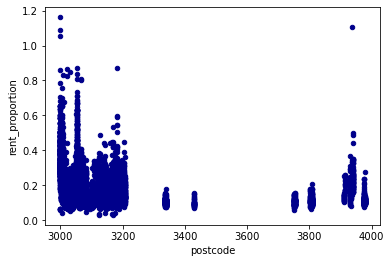

In [52]:
# draw a scatter plot to see the rent_proportion for each postcode
ax1 = df_affordable.plot.scatter(x='postcode',
                       y='rent_proportion',
                       c='DarkBlue')

In [53]:
# get the postcode list
postcode_list = df_affordable['postcode'].unique().tolist()

# check if this property is affordable
df_affordable['greater_than_30_percent_count'] = df_affordable['rent_proportion'] >= 0.3
df_affordable.head()

# get the postcode list of the postcode which contain unaffordable property
df_unaffordable = df_affordable[df_affordable['greater_than_30_percent_count'] == True]
unaffordable_postcode = df_unaffordable['postcode'].unique().tolist()

/var/folders/n7/qfvz6ksd7g59vg977hr8g0yh0000gn/T/ipykernel_18975/440104036.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_affordable['greater_than_30_percent_count'] = df_affordable['rent_proportion'] >= 0.3


In [54]:
# get the postcode list of the postcode which do not contain unaffordable property
affordable_postcode = [i for i in postcode_list if i not in unaffordable_postcode]

# convert the affordable postcode list to the dataframe
df_affordable_postcode = pd.DataFrame (affordable_postcode, columns = ['postcode'])

In [55]:
# join the property data with affordable postcode by inner join
df_affordable = df_affordable.merge(df_affordable_postcode, left_on="postcode", right_on="postcode", how='inner')
df_affordable

,postcode,bedrooms,income,price,rent_proportion,greater_than_30_percent_count
0,3029,3,1402.0,410.0,0.097480,False
1,3029,4,1402.0,420.0,0.074893,False
2,3029,4,1402.0,440.0,0.078459,False
3,3029,3,1402.0,415.0,0.098669,False
4,3029,3,1402.0,410.0,0.097480,False
...,...,...,...,...,...,...
5660,3934,3,1415.0,625.0,0.147232,False
5661,3934,4,1415.0,720.0,0.127208,False
5662,3934,4,1415.0,700.0,0.123675,False
5663,3934,3,1415.0,870.0,0.204947,False


In [56]:
# for those affordable property ,group by by postcode by mean of rent_proportion
df_affordable = df_affordable[['postcode','rent_proportion']].groupby(['postcode']).mean()

In [57]:
# sort it and get the top 10 suburb
df_affordable = df_affordable.sort_values(by=['rent_proportion']).reset_index()

In [58]:
df_affordable.to_csv('../data/raw/affordable_rank.csv')